In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# CNN Example

In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="../Pre-processing/dataset/face_dataset/", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)

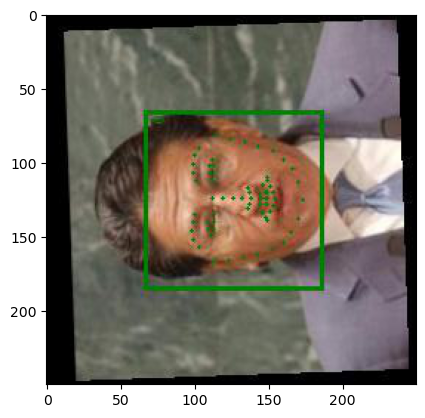

In [8]:
plt.imshow(dataset[0][0].T)

In [9]:
# images are (250, 250, 3)
# (((W - K + 2P)/S) + 1)
#         Here W = Input size
#         K = Filter size
#         S = Stride
#         P = Padding 

import torchvision.models as models

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001) 


In [10]:
num_epochs = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validate the model
    vgg16.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
data = pd.read_csv('../Pre-processing/dataset/anchor_points_dataset/pairwise_data_points.csv')


X = data.drop(columns=['label']).to_numpy()
y = data['label'].to_numpy()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
data['label'].value_counts()

label
Lleyton_Hewitt               70
Jennifer_Capriati            70
Serena_Williams              65
Jacques_Chirac               65
Gloria_Macapagal_Arroyo      65
Jean_Chretien                64
Tom_Ridge                    64
Andre_Agassi                 63
Donald_Rumsfeld              63
Vladimir_Putin               62
Tony_Blair                   62
Nestor_Kirchner              61
Junichiro_Koizumi            61
Hugo_Chavez                  61
David_Beckham                61
Ariel_Sharon                 60
Luiz_Inacio_Lula_da_Silva    59
Guillermo_Coria              58
Gerhard_Schroeder            58
Laura_Bush                   58
Kofi_Annan                   57
Arnold_Schwarzenegger        57
Colin_Powell                 56
John_Ashcroft                56
Alvaro_Uribe                 56
Juan_Carlos_Ferrero          55
Roh_Moo-hyun                 55
Silvio_Berlusconi            54
Jack_Straw                   54
Vicente_Fox                  53
Alejandro_Toledo             52
Ge

#### MetricNet 

In [ ]:
class MetricNet(nn.Module):
    def __init__(self, input_size, num_classes=(True, 10), p=1):
        super().__init__()
        
        hidden_size1 = int(input_size/2)
        hidden_size2 = int(input_size/4)
        hidden_size3 = int(input_size/8)
        hidden_size4 = int(input_size/16)
        hidden_size5 = int(input_size/32)
        
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, hidden_size3)
        self.fc5 = nn.Linear(hidden_size3, hidden_size4)
        self.fc6 = nn.Linear(hidden_size4, hidden_size5)
        if num_classes[0]:

            self.fc7 = nn.Linear(hidden_size5, num_classes[1])
        else:

            self.fc7 = nn.Linear(hidden_size5, p)
        
        
        self.relu = nn.ReLU()

        # TESTING ONLY
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x
    
    
    

model = MetricNet(input_size=input_size, num_classes=(True,num_classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10000
batch_size = 500
 
for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        ybatch = y_train_tensor[i:i+batch_size]

        y_pred = model(Xbatch)
        loss = criterion(y_pred, ybatch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred.numpy())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

KeyboardInterrupt: 

## Math stuff

In [ ]:
import torch
import torch.nn as nn

class BioNetLoss(nn.Module):
    """
    Custom loss function that computes the loss based on the given embeddings.
    Suitable for neural networks.
    """
    def __init__(self, p):
        """
        Initialize the loss function.

        Parameters:
        - p: Dimensionality of the data (int).
        """
        super(BioNetLoss, self).__init__()
        self.p = p  # Dimensionality of the feature space

    def compute_loss_term(self, mu, z_batch, sigma):
        """
        Compute a single loss term for the given total and batch embeddings.

        Parameters:
        - z_tot: Tensor of total embeddings (torch.Tensor).
        - z_batch: Tensor of batch embeddings (torch.Tensor).

        Returns:
        - Loss term value (torch.Tensor).
        """
        # Compute covariance matrice of the samples
        sigma_batch = torch.var(z_batch, dim=0, unbiased=True)
        
        # Compute determinants and inverse
        det_sigma_s = sigma_batch
        inv_sigma = 1/sigma

        # Log determinant, first term
        log_det_term = torch.log(sigma / det_sigma_s)

        # Trace term, second term
        trace_term = inv_sigma * sigma_batch

        # Last term
        diff = mu - torch.mean(z_batch, dim=0)
        lst = diff * inv_sigma * diff  

        return 0.5 * (log_det_term - self.p + trace_term + lst)

    def forward(self, mu_n, z_sn, mu_m, z_sm, sigma):
        """
        Forward pass to compute the total loss.

        Parameters:
        - z_n: Tensor of normal samples (torch.Tensor).
        - z_sn: Tensor of normal batch samples (torch.Tensor).
        - z_m: Tensor of abnormal samples (torch.Tensor).
        - z_sm: Tensor of abnormal batch samples (torch.Tensor).

        Returns:
        - Total loss value (torch.Tensor).
        """
        loss_n = self.compute_loss_term(mu_n, z_sn, sigma)
        loss_m = self.compute_loss_term(mu_m, z_sm, sigma)
        return loss_n + loss_m


def threshold(mu_n, mu_m):
    """
    Compute the threshold value for the given embeddings using PyTorch.

    Parameters:
    - z_n, z_m: Tensors of embeddings (torch.Tensor).

    Returns:
    - Threshold value (torch.Tensor).
    """
    return (mu_n + mu_m) / 2

# from the article
mu_n = torch.tensor([40])
mu_m = torch.tensor([0])
sigma = torch.tensor([[1.0]])
p = torch.tensor([1])

num_samples = 100 
z_sn = mu_n + torch.randn(num_samples, p)
z_sm = mu_m +  torch.randn(num_samples, p )

loss_function = BioNetLoss(p)

loss = loss_function(mu_n, z_sn, mu_m, z_sm, sigma)
print(f"Loss: {loss.item()}")

threshold_value = threshold(mu_n, mu_m)
print(f"Threshold: {threshold_value.item()}")



Loss: 0.032453034073114395
Threshold: 20.0
